# Image Classification
Let's consider a cat for image classification for a machine. This is a very hard problem for a machine. Because for an image of a cat the machine sees it as a big grid of number. Each grid value has pixel values of three channel (Red, Green, Blue). The probelem is therefore can be considered as semantic gap.
Moreover there are many challenges. Such as-

- viewpoint variation
- illuminision
- deformation
- occlusion (you might see part of a cat)
- background clutter
- intraclass varitation

having challenges like above it's really hard to classify image for a machine.

--> To make rules for an individual object for classification is not a good approach. Because these rules may not work for other object. For example, the rules for cat won't work for truck. Thats why we need to try another approach. And we go for data driven approach. In this approach there are  few steps. 

- Collect a dataset of images and labels
- Use machine learning to train a classifier
- Evaluate the classifier on new image

Before we start NN and CNN, we will discuss some simple classifiers.

### Nearest Neighbors

This is a very simple classification algorithm.

- During training it memorizes all the data points and labels.
- predict the label of the most similar training image

As our first approach, we will develop what we call a Nearest Neighbor Classifier. This classifier has nothing to do with Convolutional Neural Networks and it is very rarely used in practice, but it will allow us to get an idea about the basic approach to an image classification problem.
We will work with CIFAR-10 dataset.

#### Example image classification dataset:
 CIFAR-10. One popular toy image classification dataset is the CIFAR-10 dataset. This dataset consists of 60,000 tiny images that are 32 pixels high and wide. Each image is labeled with one of 10 classes (for example “airplane, automobile, bird, etc”). These 60,000 images are partitioned into a training set of 50,000 images and a test set of 10,000 images. In the image below you can see 10 random example images from each one of the 10 classes:

 Suppose now that we are given the CIFAR-10 training set of 50,000 images (5,000 images for every one of the labels), and we wish to label the remaining 10,000. The nearest neighbor classifier will take a test image, compare it to every single one of the training images, and predict the label of the closest training image.

You may have noticed that we left unspecified the details of exactly how we compare two images, which in this case are just two blocks of 32 x 32 x 3. One of the simplest possibilities is to compare the images pixel by pixel and add up all the differences. In other words, given two images and representing them as vectors I1,I2
 , a reasonable choice for comparing them might be the L1 distance:

 $d_1 (I_1, I_2) = \sum_{p} \left| I^p_1 - I^p_2 \right|$


##### Step -1 (loading the data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:

def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

CIFAR-10 data loader function

In [3]:
def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names


Let's have a look on the different datasets' size.

In [4]:
cifar_10_dir = 'dataset\cifar10'
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = load_cifar_10_data(cifar_10_dir)
print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


##### Step-02 --> visualize the dataset
It is always good to have a look on the datasets by showing them in the graph. For this purpose we use matplotlib

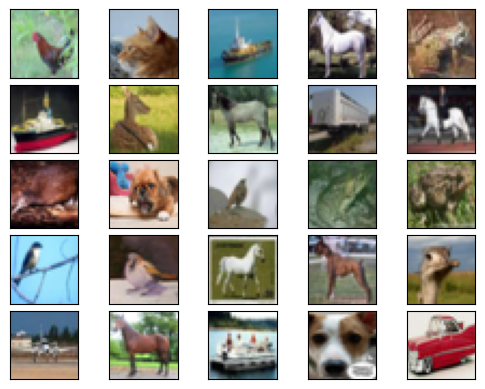

In [5]:
# display some random training images in a 25x25 grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, train_data.shape[0])
        ax[m, n].imshow(train_data[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

##### Step 3 --> Flatten out all the images to be one-dimensional

In [6]:
#Flatten out all images to be one-dimensional 
Xtr_rows = train_data.reshape(train_data.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = test_data.reshape(test_data.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

 ##### Step-4--> train and evaluation
 
 It is common to use the accuracy, which measures the fraction of predictions that were correct. Notice that all classifiers we will build satisfy this one common API: they have a train(X,y) function that takes the data and the labels to learn from. Internally, the class should build some kind of model of the labels and how they can be predicted from the data. And then there is a predict(X) function, which takes new data and predicts the labels. 

In [7]:
class NearestNeighbor(object):
  def __init__(self):
    pass
  
  def train(self, X, y):  # Memorising the data (Nearest neighbor algorithm)
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

    return Ypred

In [8]:
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(Xtr_rows, train_labels) # train the classifier on the training images and labels
Yte_predict = nn.predict(Xte_rows) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print ('accuracy: %f' % ( np.mean(Yte_predict == test_labels) ))

accuracy: 0.249200


The accuray of the model is only about 25 % which not so good.

##### The choice of distance
There are many other ways of computing distances between vectors. Another common choice could be to instead use the L2 distance,
                          $ d_2 (I_1, I_2) = \sqrt{\sum_{p} \left( I^p_1 - I^p_2 \right)^2}$

         #code: distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))
                           

# k-nearest Neighbors
Instead of copying label from a single nearest neighbor take majority vote from K closest points.
Distance can be meausred using l1(manhattan) or l2(eucledean) distance. we can tune the hyperparameters (distance measure porcedure and value of k) to get better result.

Q: what is the best value for k?
- Ans: very problem dependent. Must try them all out and see what works best


K-NN on images nevers used. Because--
- very slow to test
- distance metrix on pixels are not informative
- curse of dimensionality

    - If we want K-NN to work well, we kind of need our training examples to cover the space quite densely. Otherwise our nearest neighbors could actually be quite far away and might not acutually be very similar to our testing points. Densely covering the space means that we need a number of training examples which is exponential in the dimension of the problem. Exponentially growth is very bad. Moreover we will need huge image data set which is difficult.

### Validation set for hyper parameters

--> the goal in machine learning is not to get good result with train data or test data, it is to measure performance of the trained mdoel with respect to unseen data.

- if we choose k=1 then the train data fits the model perfectly, but it's not our goal
- if we divide the data into train and test then the hyperparameters fits the test data well and makes good result. But again these hyperparameters may not work well for unseen data
- It is more common to split the data inot 3 (train,validation, test) parts. find the best hyperparameters in while training which perfomrs best on validataion set. And after all editing,debugging the best perfoming classifier on the validation set run it once on the test set.

--> Another stragedy is cross  validation (used in small dataset). Using CIFAR-10 as an example, we could for example use 49,000 of the training images for training, and leave 1,000 aside for validation. This validation set is essentially used as a fake test set to tune the hyper-parameters.



In [9]:
## Modified nearest neighbor classifier that can take k as input

class NearestNeighbor(object):
  def __init__(self):
    pass
  
  def train(self, X, y):  # Memorising the data (Nearest neighbor algorithm)
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X,k):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = np.zeros(num_test, dtype = self.ytr.dtype)

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      # find the indices of the k nearest neighbors
      min_index = np.argsort(distances)[:k] 
      k_nearest_labels = self.ytr[min_index]
      # predict the label based on majority voting
      Ypred[i] = np.argmax(np.bincount(k_nearest_labels)) # predict the label of the nearest example

    return Ypred

by default nearest neighbor takes one closest image. But we can take multiple closest value and take the maximum voting class which we do using value of k=1,2,3......
In the below cell we will take different value of k except 1. we will take k=3,5. we should take more to sure which value of k performs well. but it's slow process. Therefore for convenience we will check with k=3,5 and see the changes.

In [10]:
# assume we have Xtr_rows, Ytr, Xte_rows, Yte as before
# recall Xtr_rows is a 50,000 x 3072 matrix

Xval_rows = Xtr_rows[:1000, :]  # take the first 1000 for validation
Yval =train_labels[:1000]
Xtr_rows = Xtr_rows[1000:, :]  # keep the last 49,000 for training
Ytr = train_labels[1000:]

# find hyperparameters that work best on the validation set
validation_accuracies = []
for k in [1, 3, 5, 10, 20, 50, 100]:   
    # use a particular value of k and evaluate on the validation data
    nn = NearestNeighbor()
    nn.train(Xtr_rows, Ytr)
    # here we assume a modified NearestNeighbor class that can take k as input
    Yval_predict = nn.predict(Xval_rows, k=k)
    acc = np.mean(Yval_predict == Yval)
    print('accuracy: %f' % (acc,))
    # keep track of what works on the validation set
    validation_accuracies.append((k, acc))

accuracy: 0.223000
accuracy: 0.236000
accuracy: 0.241000
accuracy: 0.238000
accuracy: 0.239000
accuracy: 0.217000
accuracy: 0.201000


These accuracies are for different value of k .we can see that for value 5 the accuracy is on validation set is highest.

In [13]:
for i, val in enumerate(validation_accuracies):
    print(i+1,") k=",val[0],"accuracy=",val[1])

1 ) k= 1 accuracy= 0.223
2 ) k= 3 accuracy= 0.236
3 ) k= 5 accuracy= 0.241
4 ) k= 10 accuracy= 0.238
5 ) k= 20 accuracy= 0.239
6 ) k= 50 accuracy= 0.217
7 ) k= 100 accuracy= 0.201


By the end of this procedure, we could plot a graph that shows which values of k work best. We would then stick with this value and evaluate once on the actual test set.

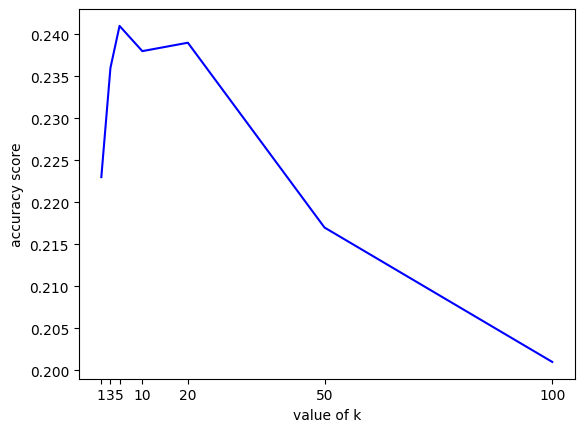

In [19]:
x_values=[t[0] for t in validation_accuracies]
y_values=[t[1] for t in validation_accuracies]

plt.xticks([1,3,5,10,20,50,100])

plt.plot(x_values,y_values,'b-')
plt.xlabel("value of k")
plt.ylabel("accuracy score")
plt.show()

We can see that for k=5 accuracy is maximum

#### Cross validation set 
The idea is instead of spliting the data ino three set we will split the data in "f" folds. {f=1,2,3,.....,n}. Say for example number of folds is 5. we will work for a set of hyperparameters with the first four folds and evalutate performance on the 5th fold, then train with 1st,2nd,3rd,5th fold and evaluate perfomance on 4th fold and so on. Finally average the performance across the different folds.In this way we will know which hyperparameter can perform better.


## Pros and Cons

#### Pros
-  very simple to implement and understand
- the classifier takes no time to train, since all that is required is to store and possibly index the training data
#### Cons
- computational cost is very high. Because in time of training an input image compares with each image in the train dataset and returns the min(s). It's copmutationally lengthy.

#### challenges
One problem is that images are high-dimensional objects (i.e. they often contain many pixels), and distances over high-dimensional spaces can be very counter-intuitive. The image below illustrates the point that the pixel-based L2 similarities we developed above are very different from perceptual similarities:


 ![alt text](crossval.png " problem with high dimensional image")


 pixel differences to compare images is inadequate. We can use a visualization technique called **t-SNE** to take the CIFAR-10 images and embed them in two dimensions so that their (local) pairwise distances are best preserved.

 In particular, note that images that are nearby each other are much more a function of the general color distribution of the images, or the type of background rather than their semantic identity. For example, a dog can be seen very near a frog since both happen to be on white background. Ideally we would like images of all of the 10 classes to form their own clusters, so that images of the same class are nearby to each other regardless of irrelevant characteristics and variations (such as the background). However, to get this property we will have to go beyond raw pixels.


# t-SNE (t- Distributed Stochastic Neighbor Embedding)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets into a lower dimension. The technique can be implemented via Barnes-Hut approximations, allowing it to be applied on large real-world datasets.


## t-SNE algorithm
**1.Computing Pairwise Similarities**:
  -Given a dataset with feature vectors X1, X2, ..., Xn, we compute pairwise similarities between them. Let's assume we have a similarity matrix S, where Sij represents the similarity between Xi and Xj.

**2.Constructing Similarity Distributions**:
 -We convert the pairwise similarities into conditional probabilities that measure the similarity between points.
 -In the high-dimensional space, we compute conditional probabilities using the Gaussian distribution. We calculate Pij, which represents the probability of choosing Xj as a neighbor given Xi, using the formula: 
 $Pij = exp(-||Xi - Xj||^2 / 2σ^2) / Σk≠i exp(-||Xi - Xk||^2 / 2σ^2)$,
  where σ is a parameter that determines the width of the Gaussian distribution.
- In the low-dimensional space, we compute conditional probabilities using the Student's t-distribution. We calculate Qij, which represents the probability of choosing Yj as a neighbor given Yi (Yi and Yj are the low-dimensional representations of Xi and Xj), using the formula:
 $Qij = (1 + ||Yi - Yj||^2)^(-1) / Σk≠i (1 + ||Yi - Yk||^2)^(-1)$.

**3.Initializing the Low-Dimensional Embedding**:
- We randomly initialize the positions of the points in the low-dimensional space. Let's say we have Y1, Y2, ..., Yn as the initial positions.

**4.Optimizing the Embedding**:
- We iteratively optimize the positions of the points in the low-dimensional space to minimize the difference between the high-dimensional and low-dimensional similarity distributions.
- We minimize the difference using gradient descent optimization. We define an objective function that measures the difference between the distributions, typically using the Kullback-Leibler (KL) divergence. The objective function can be written as: KL(P||Q) = Σi Σj Pij log(Pij / Qij), where P is the high-dimensional similarity matrix, and Q is the low-dimensional similarity matrix.
- We compute the gradient of the objective function with respect to the low-dimensional points, and update the positions of the points in the low-dimensional space accordingly.

**5.Iterating Until Convergence**:
- We repeat the optimization process for multiple iterations until the algorithm converges. Convergence is typically determined based on a predefined threshold or after a fixed number of iterations.

**6.Visualizing the Lower-Dimensional Embedding**:
- Once the algorithm has converged, we obtain the final positions of the points in the low-dimensional space.
- We can visualize the low-dimensional embedding using a scatter plot or other visualization techniques. Each point represents a data point, and its position reflects the low-dimensional representation.
- The resulting visualization shows clusters of similar points, revealing the underlying structure and relationships in the data.

In summary, t-SNE converts pairwise similarities into conditional probabilities in both the high-dimensional and low-dimensional spaces. It optimizes the positions of the points in the low-dimensional space to minimize the difference between the distributions. The resulting visualization allows us to explore and understand the relationships between data points in a lower-dimensional space.

# Linear classifier
Linear classifiers are the building blocks of neural networks. In other words linear classifier comprise neural networks. That's why it is important to learn linear classifier first.

It is also said as parametric approach.

Input(Image) ----->f(x,W)----->10 numbers giving class scores
- image=32 X32 X3 numbers (3072 numbers total)
- size(W)=10 X 3072 , size(image matrix=3072 X 1)

![alt text] (linear.PNG "Linear classifier function")




#### Interpreting Linear classifier


--> Two points of view
 - Template matching
    - learns only one template for each class. Say a template for horse consists of pixel values of green color. Therefore this template tend to choose something green as horse. although this is not the case always.
- High dimensional space (considering each image as a point in a high dimensional space)
    - Problem:
        - separatng odd from evens is diffficult task for linear classifier
        - fails to draw decision boundary for multimodal data
        
          ![alt text](linearProblem.png "problem of linear calssifier")
        
